<a href="https://colab.research.google.com/github/megmarv/AI-BioLabs/blob/Diabetes-UT-Classification/XGBoost_DFU_UT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib
import xgboost as xgb

In [9]:
# Define dataset paths
dataset_base = "/content/drive/MyDrive/DFU_UT_Dataset"
train_dir = os.path.join(dataset_base, "balanced_training")
test_dir = os.path.join(dataset_base, "balanced_validation")

In [10]:
# Load EfficientNetB1 as feature extractor
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block7b_add').output)
feature_extractor.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,160,519 (23.50 MB)

 Trainable params: 6,101,024 (23.27 MB)

 Non-trainable params: 59,495 (232.41 KB)

In [11]:
# Test the output shape
dummy_input = np.zeros((1, 224, 224, 3))
features = feature_extractor.predict(dummy_input)
print("Feature shape:", features.shape)
print("Flattened features length:", features.flatten().shape[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Feature shape: (1, 7, 7, 320)
Flattened features length: 15680


In [12]:
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,  # Reduced batch size to lower memory usage
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

# Extract features using batch processing
X_train = feature_extractor.predict(train_generator, steps=len(train_generator), verbose=1)
X_train = X_train.reshape(len(train_generator.classes), -1)

X_test = feature_extractor.predict(test_generator, steps=len(test_generator), verbose=1)
X_test = X_test.reshape(len(test_generator.classes), -1)

y_train = train_generator.classes
y_test = test_generator.classes

class_names = list(train_generator.class_indices.keys())

# Get image paths for later use
train_paths = [os.path.join(train_dir, f) for f in train_generator.filenames]
test_paths = [os.path.join(test_dir, f) for f in test_generator.filenames]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"Number of classes: {len(class_names)}")
print(f"Feature dimension: {X_train.shape[1]}")

Found 675 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 265ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 705ms/step
Training samples: 675, Testing samples: 100
Number of classes: 5
Feature dimension: 15680


In [13]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Train XGBoost with updated GPU configuration
param_grid = {'max_depth': [3, 5], 'learning_rate': [0.1]}  # Simplified grid
xgb_model = GridSearchCV(
    xgb.XGBClassifier(eval_metric='mlogloss', tree_method="hist", device="cuda", n_jobs=1),
    param_grid, cv=2, n_jobs=1, verbose=3
)
xgb_model.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END ....learning_rate=0.1, max_depth=3;, score=0.743 total time=  19.0s
[CV 2/2] END ....learning_rate=0.1, max_depth=3;, score=0.742 total time=  20.6s
[CV 1/2] END ....learning_rate=0.1, max_depth=5;, score=0.731 total time=  31.6s
[CV 2/2] END ....learning_rate=0.1, max_depth=5;, score=0.736 total time=  39.9s


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1, param_grid={'learning_rate': [0.1], 'max_depth': [3, 5]},
             verbose=3)

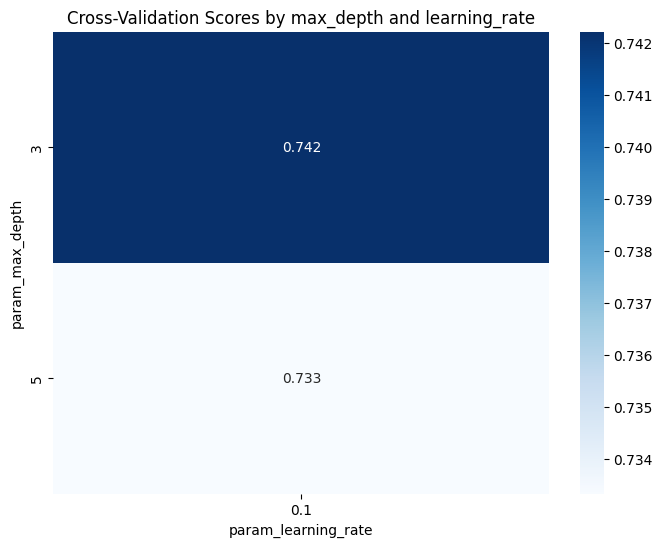

Best parameters: {'learning_rate': 0.1, 'max_depth': 3}
Best cross-validation score: 0.742


In [15]:
# Visualize cross-validation results
results = pd.DataFrame(xgb_model.cv_results_)
pivot_table = results.pivot(index='param_max_depth', columns='param_learning_rate', values='mean_test_score')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.3f')
plt.title('Cross-Validation Scores by max_depth and learning_rate')
plt.show()

print(f"Best parameters: {xgb_model.best_params_}")
print(f"Best cross-validation score: {xgb_model.best_score_:.3f}")

In [16]:
# Evaluate classifier
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 88.00%

Classification Report:

                      precision    recall  f1-score   support

             Grade 0       0.78      0.90      0.84        20
             Grade 1       1.00      0.85      0.92        20
             Grade 2       0.82      0.90      0.86        20
             Grade 3       0.86      0.95      0.90        20
Normal(Healthy skin)       1.00      0.80      0.89        20

            accuracy                           0.88       100
           macro avg       0.89      0.88      0.88       100
        weighted avg       0.89      0.88      0.88       100



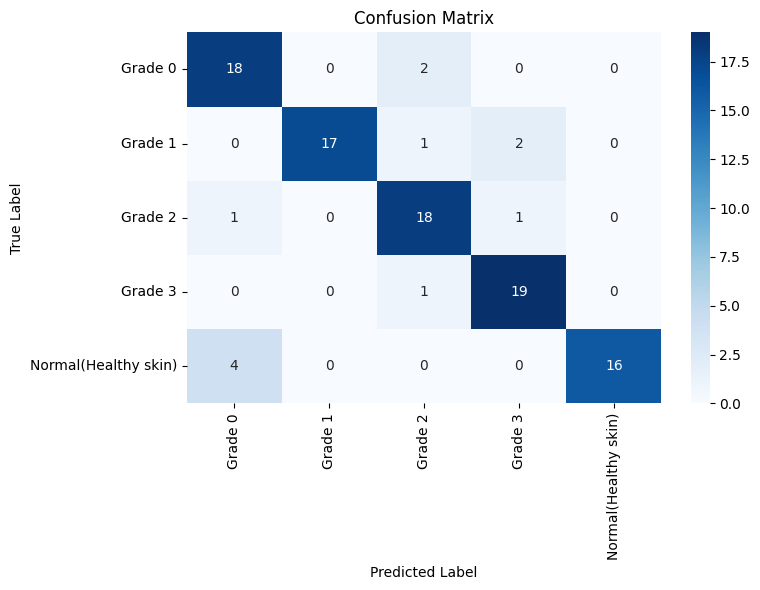

In [17]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

<ipython-input-18-3972003902>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=label_accuracies, palette='viridis')


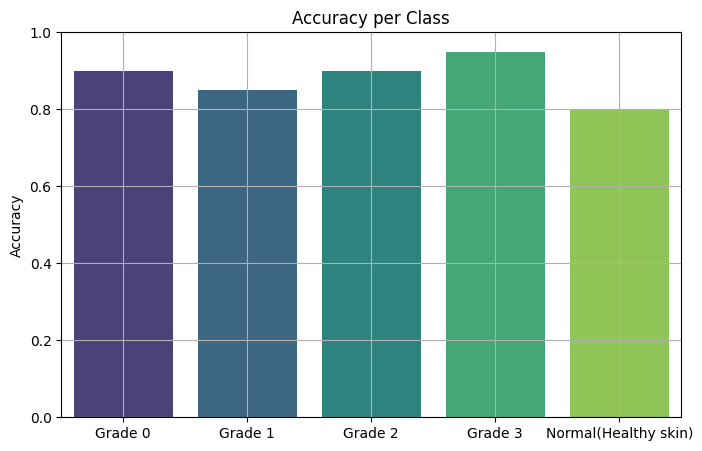

In [18]:
# Accuracy bar plot
correct = (y_pred == y_test)
label_accuracies = []
for i, class_name in enumerate(class_names):
    indices = (y_test == i)
    acc = np.sum(correct[indices]) / np.sum(indices) if np.sum(indices) > 0 else 0
    label_accuracies.append(acc)

plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=label_accuracies, palette='viridis')
plt.ylabel("Accuracy")
plt.title("Accuracy per Class")
plt.ylim(0, 1.0)
plt.grid(True)
plt.show()

In [19]:
# Save models
feature_extractor.save("xgb_feature_extractor_v2.keras")
joblib.dump(xgb_model, "xgb_classifier_v2.joblib")
joblib.dump(scaler, "xgb_scaler_v2.joblib")
print("Feature extractor, classifier, and scaler saved.")

Feature extractor, classifier, and scaler saved.


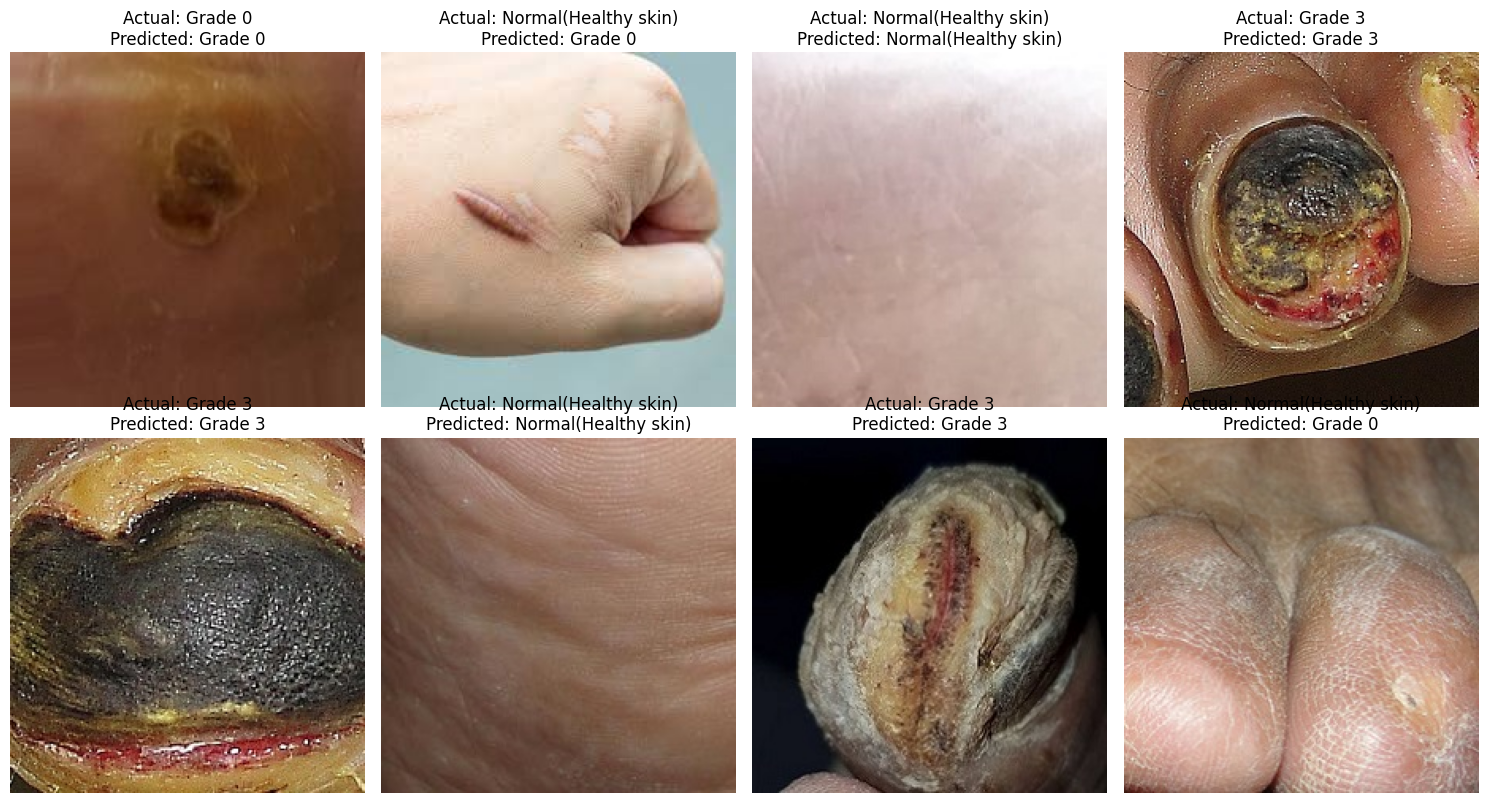

In [21]:
# Cell 12: Display predictions on 8 random test images
from tensorflow.keras.preprocessing import image  # Added import here
indices = random.sample(range(len(test_paths)), 8)
selected_images = [test_paths[i] for i in indices]
selected_labels = y_test[indices]

features = X_test_scaled[indices]
predictions = xgb_model.predict(features)

plt.figure(figsize=(15, 8))
for i in range(8):
    img_path = selected_images[i]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    actual = class_names[selected_labels[i]]
    predicted = class_names[predictions[i]]
    plt.title(f"Actual: {actual}\nPredicted: {predicted}")
    plt.axis('off')
plt.tight_layout()
plt.show()